## Setup

In [ ]:
!pip install emukit
!pip install GPy
!pip install GPyOpt
!pip install SALib
import GPy
from GPyOpt.methods import BayesianOptimization
from emukit.model_wrappers import GPyModelWrapper
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
from emukit.core import ContinuousParameter, ParameterSpace
from SALib.sample import saltelli
from SALib.analyze import sobol

from google.colab import drive
import os
import pickle
import itertools
from IPython.display import clear_output

import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import scipy

import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

clear_output()
print("Loaded dependencies.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 kB 2.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emukit: filename=emukit-0.4.10-py3-none-any.whl size=257050 sha256=d99314dc686b5fcdf22c088d3d8b4caf75f28129e6629ee6ab63a47a8bfe3a39
  Stored in directory: /root/.cache/pip/wheels/30/d1/af/64ddede19b5eb77bd70362edebf9d393bf77dc34d354c11292
  Created wheel for matplotlib: filename=matplotlib-3.3.4-cp310-cp310-linux_x86_64.whl size=11684740 sha256=d501556c5845d07cb37fc859798b1be87d35351b78f13385c5a9

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for GPyOpt: filename=GPyOpt-1.2.6-py3-none-any.whl size=83588 sha256=813b3251364904939f15d67a77487b2670aff0d587e51c63e4a8a182ecd1e47b
  Stored in directory: /root/.cache/pip/wheels/72/17/52/9d818b4c60f733bf49d5cf82bc2758ebbdc57a0471137c37be
Successfully built GPyOpt


In [ ]:
"""
!pip install GPy
import GPy
from IPython.display import clear_output

!pip install GPyOpt
import GPyOpt
from GPyOpt.methods import BayesianOptimization


!pip install emukit
import GPy
from emukit.model_wrappers import GPyModelWrapper
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
from emukit.core import ContinuousParameter, ParameterSpace


!pip install SALib
from SALib.sample import saltelli
from SALib.analyze import sobol


clear_output()


"""

'\n!pip install GPy\nimport GPy\nfrom IPython.display import clear_output\n\n!pip install GPyOpt\nimport GPyOpt\nfrom GPyOpt.methods import BayesianOptimization\n\n\n!pip install emukit\nimport GPy\nfrom emukit.model_wrappers import GPyModelWrapper\nfrom emukit.sensitivity.monte_carlo import MonteCarloSensitivity\nfrom emukit.core import ContinuousParameter, ParameterSpace\n\n\n!pip install SALib\nfrom SALib.sample import saltelli\nfrom SALib.analyze import sobol\n\n\nclear_output()\n\n\n'

In [ ]:

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


## Input crutch variables HERE

In [ ]:

EXPERIMENT = 'BO_loop'

crutch_type = '80_120_25'


crutch_parameters = [80,   #ALPHA: angle of handle from vertical  - Degrees
                     120,    #BETA: Angle between forearm placement and hand grip - Degrees
                     25]   #GAMMA: Distance between forearm placement and vertical strut -- in CM

subjective_crutch_results = [4,            #subjective PAIN / 6
                             2,     #subjective INSTABILITY /6
                             3]         #subjective EFFORT /6
## where 1 is awesome, 6 is terrible


HR_change_raw = 35


# Calculated by taking the final HR after crutching - initial HR when starting cruthing
#this is currently measured just after experiment,
#but can be calculataed from heart monitor data automatically (not done here)


#~~~~~~~~~~~ EXPERIMENTAL DECISIONS

Num_bouts_predefined = 6
## edit the accelerometer data to only use this number of bouts


Initial_crutches_BO_loop = ['NHS_2', 'smart', 'opmo']


Metric_weighting_values_dict ={
    'standard_deviation_scale_factor': 20,
    'bouts_num_diff':2,
    'Y_change': 100,
    'X_Z_change': 100,
    'Y_total': 3000,
    'HR_change': 5,
    'step_freq': 5,
    'Impact_Subj_metrics':1,
    'Impact_Obj_metrics': 1, # this value is multiplied to the total objective loss
    'Impact_Sim_metrics':1,  #this value is multiplied to the simulated loss,
    'Dim_beta_kern_noise': 1.05  # value of the noise prior on the beta dimension of the BO kernel
    }


acc_file = crutch_type + '_acc.csv'
step_file = crutch_type + '_step.step'

## Download all previous runs

In [ ]:


# List files in your Google Drive root directory
ML_phys_experiments = '/content/drive/My Drive/MLPhys Crutches/Experiments'

files = os.listdir(ML_phys_experiments)
print(files)

['NHS_acc.csv', 'NHS_experiment_1.csv', 'NHS_Step.step', 'Crutches experiments .gsheet', '110_140_20_acc (1).csv', '70_130_21_acc.csv', '70_130_21_step.step', '110_140_20_acc.csv', '110_140_20_step.step', 'angled_acc.csv', 'angled_step.step', 'opmo_acc.csv', 'opmo_step.step', 'smart_acc.csv', 'smart_step.step', 'Plots', '90_140_90_acc.csv', '90_140_90_step.step', 'NHS_step.step', '85_135_85_acc.csv', '85_135_85_step.step', 'NHS_2_acc.csv', 'NHS_2_step.step', 'Experiment_metrics.pkl']


In [ ]:
def find_unique_crutch_titles(file_list, ):
    """
    This function takes a list of file names and returns the unique titles
    of the files that end with '_acc.csv'.
    """
    acc_files = set()  # Using a set to store unique titles
    step_files = set()
    for file in file_list:
        if file.endswith('_acc.csv'):
            title = file[:-8]  # Remove '_acc.csv' from the file name to get the title
            acc_files.add(title)
        elif file.endswith('_step.step'):
          title = file[:-10]
          step_files.add(title)

    complete_crutch_data = acc_files.intersection(step_files)


    return(list(complete_crutch_data))

In [ ]:
"""
unique_crutches  = find_unique_crutch_titles(files)



file_path_unique_crutches = f'/content/drive/My Drive/MLPhys Crutches/Experiments/Experiment_metrics/unique_crutches.pkl'
try:
    with open(file_path_unique_crutches, 'wb') as file:
        pickle.dump(unique_crutches, file)
except Exception as e:
    print(f"Error saving to pickle file: {e}")



unique_crutches
"""

'\nunique_crutches  = find_unique_crutch_titles(files)\n\n\n\nfile_path_unique_crutches = f\'/content/drive/My Drive/MLPhys Crutches/Experiments/Experiment_metrics/unique_crutches.pkl\'\ntry:\n    with open(file_path_unique_crutches, \'wb\') as file:\n        pickle.dump(unique_crutches, file)\nexcept Exception as e:\n    print(f"Error saving to pickle file: {e}")\n\n\n\nunique_crutches\n'

In [ ]:
file_path_unique_crutches = f'/content/drive/My Drive/MLPhys Crutches/Experiments/Experiment_metrics/unique_crutches.pkl'

if os.path.exists(file_path_unique_crutches):  # Check if the file exists
    try:
        with open(file_path_unique_crutches, 'rb') as file:
            unique_crutches = pickle.load(file)
    except Exception as e:
        print(f"Error loading pickle file: {e}")


In [ ]:
crutch_geometries = {
    'angled_angledup': [135, 95, 15],
    '75_125_3': [75, 125, 3],
    'angled': [90, 140, 12],
    '85_135_85': [85, 135, 8.5],
    'NHS_2': [100, 95, 3],
    '110_100_12': [110, 100, 12],
    '110_140_20': [110, 140, 20],
    'smart': [140, 140, 0],
    '70_130_21': [70, 130, 21],
    '90_140_90': [90,140, 9],
    'NHS': [100, 95, 3],
    'opmo': [90, 140, 30]

}

subjective_metrics_all_crutches = {
    'angled_angledup': [2, 2, 3, 20],
    '75_125_3': [ 1, 1, 1, 20],
    'angled': [ 3,3,3, 40 ],
    '85_135_85': [2, 3, 1, 35],
    'NHS_2': [ 5, 3, 2, 35],
    '110_100_12': [5, 2, 4, 35],
    '110_140_20': [4, 3, 2, 45],
    'smart': [ 1, 4, 5, 45],
    '70_130_21': [3, 4, 3 ,40],
    '90_140_90': [3,4, 2, 35],
    'NHS': [ 6, 2, 3, 40],
    'opmo': [1, 2, 2, 40]


}

In [ ]:
unique_crutches

NameError: name 'unique_crutches' is not defined

In [ ]:
crutch = unique_crutches[2]


crutch_type = crutch
crutch_parameters = crutch_geometries[crutch]
subjective_crutch_results = subjective_metrics_all_crutches[crutch][0:3]
HR_change_raw = subjective_metrics_all_crutches[crutch][3]



acc_file = crutch_type + '_acc.csv'
step_file = crutch_type + '_step.step'


EXPERIMENT = 'Sensitivity_analysis'

## Accelerometer data extraction

In [ ]:


# List files in your Google Drive root directory
ML_phys_root = '/content/drive/My Drive/MLPhys Crutches'

files = os.listdir(ML_phys_root)
print(files)

['crutch analysis v0.09.html', 'example_accelerometer (1).gsheet', 'example_accelerometer.csv', 'HQ MLP_crutches.gdoc', 'example_accelerometer.gsheet', 'example.step', 'Instructions_on_html_crutches.txt', 'PDN_2206jb.pdf', 'Simulator.gdoc', 'Experiments', '__pycache__', 'custom_ker.py']


In [ ]:

def load_csv_to_dataframe(file_path):
    """
    Load a .csv file into a Pandas DataFrame.

    Parameters:
    file_path (str): The path to the .csv file.

    Returns:
    pandas.DataFrame: The loaded DataFrame.
    """
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return None


In [ ]:
#Load accelerometer data
file_path_acc = '/content/drive/My Drive/MLPhys Crutches/Experiments/' + acc_file
#data_frame = load_csv_to_dataframe(file_path_acc)
data_frame = pd.read_csv(file_path_acc, error_bad_lines=False)

Accelerometer_df = data_frame[['acc_x_time', 'acc_x_data', 'acc_y_data', 'acc_z_data']].dropna()
Accelerometer_df.rename(columns={'acc_x_time': 'Time_ms'}, inplace = True)
#Accelerometer_df[['Time_ms']] = Accelerometer_df[['Time_ms']]/1000

<ipython-input-13-972dd7e5ebca>:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data_frame = pd.read_csv(file_path_acc, error_bad_lines=False)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/MLPhys Crutches/Experiments/80_120_25_acc.csv'

In [ ]:
Accelerometer_df

In [ ]:
#load step data

file_path_step = '/content/drive/My Drive/MLPhys Crutches/Experiments/' + step_file
Steps_df = load_csv_to_dataframe(file_path_step)
Steps_df = Steps_df.reset_index().rename(columns={'index': 'Step times'})
Steps_df = Steps_df.rename(columns={'Step Times': 'Step amplitude'})
Steps_df

In [ ]:
# automatically detect the start and end of the crutch bout times



# Extract the 'Step times' column for clustering
step_times = Steps_df['Step times'].values.reshape(-1, 1)

# Apply DBSCAN clustering
# Note: You might need to adjust 'eps' and 'min_samples' based on your data
dbscan = DBSCAN(eps=2, min_samples=3).fit(step_times)

# Assign cluster labels
Steps_df['crutch_bout'] = dbscan.labels_ + 1

# determine the start and end times of each crutch bout
cluster_summary = Steps_df.groupby('crutch_bout')['Step times'].agg(['first', 'last'])


print("Discovered " + str(cluster_summary.shape[0]) +  " crutching bouts" )


cluster_summary

In [ ]:
Steps_df['step_label'] = Steps_df.groupby('crutch_bout').cumcount() + 1
Steps_df

In [ ]:
#apply the start and end of each crutch bout to the accelerometer data

Accelerometer_df['Crutch_bout'] = False

# Iterate through each cluster
for index, row in cluster_summary.iterrows():
    # Select data points within the time range of the cluster
    print(row['first'], row['last'])
    mask = (Accelerometer_df['Time_ms'] >= row['first']) & (Accelerometer_df['Time_ms'] <= row['last'])

    # Annotate these data points with the cluster label
    Accelerometer_df.loc[mask, 'Crutch_bout'] = index


Accelerometer_df

In [ ]:
#apply individual step count to accelerometer data (resetting at each bout)

for index, row in Steps_df.iterrows():
    step_time = row['Step times']
    step_label = row['step_label']

    # Find the closest time in accelerometer_df to the step time
    # and label it with the step_label
    time_tolerance = 0.5  # seconds, adjust as necessary
    mask = abs(Accelerometer_df['Time_ms'] - step_time) <= time_tolerance
    Accelerometer_df.loc[mask, 'step_label'] = step_label

In [ ]:
# Remove all accelerometer data that is not related to crutching


Accelerometer_df_only_bouts = Accelerometer_df[Accelerometer_df['Crutch_bout'] != False]
Accelerometer_df_only_bouts

In [ ]:
## ONLY KEEP THE FIRST Num_bouts_predefined BOUTS OF CRUTCHING

#lower_bound = 2  # Define the lower bound
#upper_bound = 8  # Define the upper bound

#Accelerometer_df_only_bouts = Accelerometer_df_only_bouts[
#    (Accelerometer_df_only_bouts['Crutch_bout'] >= lower_bound) &
#    (Accelerometer_df_only_bouts['Crutch_bout'] <= upper_bound)
#]

Accelerometer_df_only_bouts = Accelerometer_df_only_bouts[Accelerometer_df_only_bouts['Crutch_bout'] <= Num_bouts_predefined]
Accelerometer_df_only_bouts

In [ ]:
Steps_df = Steps_df[Steps_df['crutch_bout'] <= Num_bouts_predefined]
Steps_df


In [ ]:

total_steps = []
for i in np.unique(Steps_df['crutch_bout']):
  max_num_steps_in_bout = Steps_df[Steps_df['crutch_bout']==i]['step_label'].max()
  total_steps.append(max_num_steps_in_bout)

total_steps = np.sum(total_steps)
total_steps

## Accelerometer Visualisations

In [ ]:
def save_image(title, crutch):
  save_path = f'/content/drive/My Drive/MLPhys Crutches/Experiments/Plots/' + title + crutch + '.png'
  # Save the plot
  plt.savefig(save_path)
  print(f"Plot saved to {save_path}")

In [ ]:

step_frequency_std_per_bout = []
average_step_frequency_per_bout = []

standard_deviation_scale_factor = Metric_weighting_values_dict['standard_deviation_scale_factor']

# Calculate standard deviations and averages
for i, bout in enumerate(sorted(Steps_df['crutch_bout'].unique())):
    bout_data = Steps_df[Steps_df['crutch_bout'] == bout]
    step_frequency_std_per_bout.append(bout_data['Step times'].diff().dropna().std()*standard_deviation_scale_factor)
    average_step_frequency_per_bout.append(bout_data['Step times'].diff().dropna().mean())

# Create the plot
plt.figure(figsize=(10, 6))  # Make it larger and more readable

# Plotting
plt.plot(step_frequency_std_per_bout, label='Standard Deviation (scaled)', color='blue', linestyle='-', marker='o')  # Std deviations
plt.plot(average_step_frequency_per_bout, label='Average', color='red', linestyle='--', marker='x')  # Averages

# Adding labels and title
plt.title('Step Frequency Analysis')
plt.xlabel('Bout Number')
plt.ylabel('Frequency (seconds)')
plt.title(crutch_type)

# Add a legend
plt.legend()

# Saving the image
save_image('Step_freq_', crutch_type )

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming Accelerometer_df_only_bouts is your DataFrame

# Calculate global means
global_mean_y = np.mean(np.abs(Accelerometer_df_only_bouts['acc_y_data']))
global_mean_x = np.mean(np.abs(Accelerometer_df_only_bouts['acc_x_data']))
global_mean_z = np.mean(np.abs(Accelerometer_df_only_bouts['acc_z_data']))

# Initialize lists for storing normalized sums
normalized_sums_y = []
normalized_sums_x = []
normalized_sums_z = []
bouts = []

# Iterate over each unique bout
for bout in sorted(Accelerometer_df_only_bouts['Crutch_bout'].unique()):
    bout_data = Accelerometer_df_only_bouts[Accelerometer_df_only_bouts['Crutch_bout'] == bout]

    # Calculate normalized sums
    norm_sum_y = np.sum(np.abs(bout_data['acc_y_data'])) / global_mean_y
    norm_sum_x = np.sum(np.abs(bout_data['acc_x_data'])) / global_mean_x
    norm_sum_z = np.sum(np.abs(bout_data['acc_z_data'])) / global_mean_z

    #norm_sum_y = (np.sum(np.abs(bout_data['acc_y_data']- global_mean_y))/global_mean_y) /total_steps

    #norm_sum_x = (np.sum(np.abs(bout_data['acc_x_data']- global_mean_x))/global_mean_x) /total_steps

    #norm_sum_z = (np.sum(np.abs(bout_data['acc_z_data']- global_mean_z))/global_mean_z) /total_steps


    # Store the results
    normalized_sums_y.append(norm_sum_y)
    normalized_sums_x.append(norm_sum_x)
    normalized_sums_z.append(norm_sum_z)
    bouts.append(bout)

# Create line plots
plt.figure(figsize=(15, 6))

# Plotting each axis data as a line
plt.plot(bouts, normalized_sums_y, marker='o', label='Normalized Y')
plt.plot(bouts, normalized_sums_x, marker='o', label='Normalized X')
plt.plot(bouts, normalized_sums_z, marker='o', label='Normalized Z')

# Adding labels and title
plt.xlabel('Crutch Bout')
plt.ylabel('Normalized Sum')
plt.title('Accelerometer data across bouts for '+ crutch_type)
plt.xticks(bouts)
plt.legend()

save_image('Acc_bouts', crutch_type)

# Show the plot
plt.show()




## Experimental Metrics

#### Subjective metrics

In [ ]:
Sum_subjective_metrics = np.sum(subjective_crutch_results)

weighted_sum_subjective_metrics = np.round(Sum_subjective_metrics*Metric_weighting_values_dict['Impact_Subj_metrics'],1)
print('Sum of subjective metrics = ' + str(Sum_subjective_metrics))
print('Weighted sum of subjective metrics = ' + str(weighted_sum_subjective_metrics))


#### Objective metrics

In [ ]:


def experiment_summary_metric_calc(y, x, z, weight_values):
  bouts_num_diff = weight_values['bouts_num_diff']

  Y_change = np.round(np.abs(np.sum(normalized_sums_y[0:bouts_num_diff]) - np.sum(normalized_sums_y[-bouts_num_diff:]))/weight_values['Y_change'], 1)

  X_Z_change = np.round(
      (np.abs(np.sum(normalized_sums_x[0:bouts_num_diff]) - np.sum(normalized_sums_x[-bouts_num_diff:])) +
        np.abs(np.sum(normalized_sums_z[0:bouts_num_diff]) - np.sum(normalized_sums_z[-bouts_num_diff:]))
        ) /weight_values['X_Z_change'] ,1)

  Y_total = np.round(np.sum(normalized_sums_y) / weight_values["Y_total"],1)
  #absolute_X_Z = -(np.sum(normalized_sums_x) + np.sum(normalized_sums_z))

  #summary_metric_woEM = np.round(Y_change + X_Z_change + absolute_Y/weight_values[2],1)


  return(Y_change, X_Z_change, Y_total)


In [ ]:
Y_change, X_Z_change, Y_total = experiment_summary_metric_calc(normalized_sums_y,
                                                                  normalized_sums_x,
                                                                  normalized_sums_z,
                                                                  Metric_weighting_values_dict)




#total_num_steps

Total_step_freq_variation = np.round(np.sum(step_frequency_std_per_bout)  ,1)

Adjusted_Step_freq = np.round(Metric_weighting_values_dict['step_freq']/np.mean(average_step_frequency_per_bout),1)

adjusted_HR_change = np.round(HR_change_raw/Metric_weighting_values_dict['HR_change'],1)

objective_metrics_results = [adjusted_HR_change, Total_step_freq_variation, Adjusted_Step_freq, Y_change, X_Z_change, Y_total]

Sum_objective_metrics = np.round(np.sum( objective_metrics_results ),1)


print(f"""Y_change: {Y_change}
X_Z_change: {X_Z_change}
Y_total: {Y_total}
Total_step_freq_variation: {Total_step_freq_variation}
Adjusted_Step_freq: {Adjusted_Step_freq}
adjusted_HR_change: {adjusted_HR_change}
""")

print("Sum of objective metrics = " + str(Sum_objective_metrics))

weighted_sum_objective_metrics = np.round(Sum_objective_metrics*Metric_weighting_values_dict['Impact_Obj_metrics'],1)

print("Weighted Sum of objective metrics = " + str(weighted_sum_objective_metrics))



#### Simulated metrics

In [ ]:

simulated_metrics = 0

weighted_simulated_metrics = simulated_metrics*Metric_weighting_values_dict['Impact_Sim_metrics']



#### Combined metrics

In [ ]:
total_sum_objective_subjective =  weighted_sum_objective_metrics + weighted_sum_subjective_metrics + weighted_simulated_metrics
print(f"Sum of weighted objective, subjective and simulated metrics for crutch {crutch_type}  = {total_sum_objective_subjective}")


## Loading Experiment_Metrics datasets



In [ ]:
def load_pickle_file(file_path):
    """Load a pickle file from the given file path."""
    try:
        with open(file_path, 'rb') as file:
            return pickle.load(file)
    except Exception as e:
        raise IOError(f"Error loading pickle file: {e}")


def load_pickle_experiment_dict(Experiment):
    """Load Experiment metrics dictionary from a pickle file based on the Experiment identifier."""
    # Validate the Experiment parameter
    if not isinstance(Experiment, str):
        raise ValueError("Experiment must be a string identifier")

    base_path = '/content/drive/My Drive/MLPhys Crutches/Experiments/Experiment_metrics'
    file_path = f'{base_path}/Experiment_metrics_{Experiment}.pkl'

    if Experiment == 'EMPTY':
        return {}

    if os.path.exists(file_path):
        print(f"Loading up {Experiment} Experiment Metrics! ")
        return load_pickle_file(file_path)
    else:
        print(f"No metrics file found for Experiments {Experiment}, loading from ALL")
        # Fallback to ALL file if specific file does not exist
        all_file_path = f'{base_path}/Experiment_metrics_ALL.pkl'
        if os.path.exists(all_file_path):
            return load_pickle_file(all_file_path)
        else:
            raise FileNotFoundError(f"No metrics file found for ALL Experiments {Experiment}")


In [ ]:

def convert_experiment_dict_to_df(Experiment_metrics_dict, previous_df = None):
  crutch_values_column_names = ["crutch_name", "alpha", "beta", "gamma"]
  subjective_column_names = ["subjective_joint_pain", "subjective_instability", "subjective_effort"]
  objective_clumn_names = ["HR_change", 'total_step_freq_variation', 'Step_freq', 'Y_change', 'X_Z_change', 'total_Y' ]
  simulation_col_name = ['Simulated_weighted']
  totals_col_name = ['Total_weighted_subjective', 'Total_weighted_objective', 'Total_Combined_Loss']


  all_column_names = crutch_values_column_names + subjective_column_names + objective_clumn_names + simulation_col_name + totals_col_name

  if previous_df == None:
    Experiment_metrics_df = pd.DataFrame(columns=all_column_names)
  else:
    Experiment_metrics_df = previous_df

  # Iterate over each key-value pair in Experiment_metrics_dict
  for crutch, metrics in Experiment_metrics_dict.items():
      # Check if the current 'crutch' is not in the 'crutch_name' column
      if crutch not in Experiment_metrics_df['crutch_name'].values:
          # Add the metrics to the DataFrame
          Experiment_metrics_df.loc[len(Experiment_metrics_df)] = metrics
          print(f"Adding {crutch} to Experiment_metrics_df")

  return(Experiment_metrics_df)



In [ ]:
#Experiment_metrics_dict = load_pickle_experiment_dict(EXPERIMENT)


In [ ]:
#convert_experiment_dict_to_df(Experiment_metrics_dict)

## Updating experimental metrics & saving

In [ ]:
#Experiment_metrics_dict.pop('NHS', None)
#Experiment_metrics_dict

In [ ]:
# ADDING ALL METRICS


if crutch_type not in Experiment_metrics_dict:
  Experiment_metrics_dict[crutch_type] = [crutch_type] + crutch_parameters + \
                                        subjective_crutch_results + \
                                        objective_metrics_results + \
                                        [weighted_simulated_metrics] + \
                                        [weighted_sum_subjective_metrics] + \
                                        [weighted_sum_objective_metrics] + \
                                        [total_sum_objective_subjective]




  print(f"Key '{crutch_type}' metrics added to the Experiment_metrics_dict.")
else:
  print(f"'{crutch_type}' metrics already in Experiment_metrics_dict.")



In [ ]:

#SAVING DICT IN APPROPRIATE LOCATIONS

# SAVE every run to an Experiment_metrics_ALL
file_path = f'/content/drive/My Drive/MLPhys Crutches/Experiments/Experiment_metrics/Experiment_metrics_ALL.pkl'
try:
    with open(file_path, 'wb') as file:
        pickle.dump(Experiment_metrics_dict, file)
    print(f"{crutch_type} experiment_metrics saved to ALL pickle file.")
except Exception as e:
    print(f"Error saving to pickle file: {e}")


# SAVE every run to an Experiment_metrics_ALL
file_path = f'/content/drive/My Drive/MLPhys Crutches/Experiments/Experiment_metrics/Experiment_metrics_Sensitivity_analysis.pkl'
try:
    with open(file_path, 'wb') as file:
        pickle.dump(Experiment_metrics_dict, file)
    print(f"{crutch_type} experiment_metrics saved to Sensitivity_analysis pickle file.")
except Exception as e:
    print(f"Error saving to pickle file: {e}")



if crutch_type in Initial_crutches_BO_loop:
  print(f"{crutch_type} experiment_metrics saved to {EXPERIMENT} as PRIOR.")
else:
  print(f"{crutch_type} experiment_metrics saved to {EXPERIMENT} as NEW DATA.")

file_path = f'/content/drive/My Drive/MLPhys Crutches/Experiments/Experiment_metrics/Experiment_metrics_{EXPERIMENT}.pkl'

try:
  with open(file_path, 'wb') as file:
      pickle.dump(Experiment_metrics_dict, file)
  print(f"Experiment_metrics successfully saved to {EXPERIMENT} pickle file.")
  #print(f"{crutch_type} experiment_metrics successfully saved to {EXPERIMENT} pickle file.")

except Exception as e:
  print(f"Error saving to pickle file: {e}")





In [ ]:
Experiment_metrics_df = convert_experiment_dict_to_df(Experiment_metrics_dict)
Experiment_metrics_df


In [ ]:
## IF NEED TO ADJUST EXPERIMENT METRICS MANUALLY
"""
Experiment_metrics. pop('90_140_90', None)
Experiment_metrics
"""

## Correlations amongst results

In [ ]:
EXPERIMENT = 'Sensitivity_analysis'

Experiment_metrics_dict = load_pickle_experiment_dict(EXPERIMENT)
Experiment_metrics_df = convert_experiment_dict_to_df(Experiment_metrics_dict)
Experiment_metrics_df

In [ ]:
def is_flexible(name):
    return int(name[0].isdigit())

Experiment_metrics_df['flexible'] = Experiment_metrics_df['crutch_name'].apply(is_flexible)
Experiment_metrics_df['not flexible'] = 1 - Experiment_metrics_df['flexible']

print(Experiment_metrics_df.head())

In [ ]:

def calculate_all_possible_correlations(df):
    """
    Calculate correlations for all possible group-to-group combinations of columns in the dataframe
    while avoiding repetitions.

    :param df: The DataFrame containing the data.
    :return: A DataFrame containing the correlation values for each group-to-group combination.
    """
    # Excluding the first four columns and taking the next 8 columns
    columns = df.columns

    # Filter only numeric columns
    numeric_columns = df[columns].select_dtypes(include='number').columns
    num_cols = len(numeric_columns)

    correlations = []
    processed_combinations = set()  # Set to keep track of processed combinations

    # Loop over all possible group sizes for the first group
    for group_size_1 in range(1, num_cols):
        # Generate all combinations for the first group
        for cols_group_1 in itertools.combinations(numeric_columns, group_size_1):
            group_col_name_1 = '_'.join(cols_group_1)
            df[group_col_name_1] = df[list(cols_group_1)].sum(axis=1)

            # Loop over all possible group sizes for the second group
            for group_size_2 in range(1, num_cols - group_size_1 + 1):
                # Generate all combinations for the second group
                for cols_group_2 in itertools.combinations(numeric_columns, group_size_2):
                    if not set(cols_group_1).isdisjoint(set(cols_group_2)):
                        continue  # Skip if there is overlap between groups

                    group_col_name_2 = '_'.join(cols_group_2)
                    df[group_col_name_2] = df[list(cols_group_2)].sum(axis=1)

                    # Sort and join group names to create a unique identifier for the combination
                    combination_identifier = tuple(sorted([group_col_name_1, group_col_name_2]))

                    # Check if this combination has already been processed
                    if combination_identifier in processed_combinations:
                        continue  # Skip this combination as it's already processed

                    # Calculate the correlation between the two groups
                    corr_value = df[group_col_name_1].corr(df[group_col_name_2])
                    correlations.append({
                        'Group 1': group_col_name_1,
                        'Group 2': group_col_name_2,
                        'Correlation': corr_value
                    })

                    # Add the combination to the processed set
                    processed_combinations.add(combination_identifier)

    return pd.DataFrame(correlations)

# Example usage
# df = your_dataframe
# correlation_df = calculate_all_possible_correlations(df)


In [ ]:

def plot_symmetric_pairwise_correlation_heatmap(df, part='full', save_as_pdf=True, filename='/content/drive/My Drive/MLPhys Crutches/Experiments/Plots/Correlation_Heatmap.pdf'):
    """
    Plot a symmetric pairwise correlation heatmap for the DataFrame columns.
    The colormap is adjusted so that grey represents a correlation of 0.
    Manually drawn light grey grid lines are added between heatmap cells.
    Optionally saves the plot as a PDF.

    :param df: The DataFrame containing the data.
    :param part: String, if 'lower', shows the lower triangular part;
                 if 'upper', shows the upper triangular part;
                 if 'full', shows the full heatmap.
    :param save_as_pdf: Boolean, if True, saves the plot as a PDF.
    :param filename: String, the name of the file to save the plot to.
    """
    # Calculate the symmetric pairwise correlation matrix
    correlation_matrix = df.corr()

    # Creating a mask for the upper or lower triangle
    mask = np.zeros_like(correlation_matrix, dtype=bool)

    if part == 'lower':
        mask[np.triu_indices_from(mask)] = True
    elif part == 'upper':
        mask[np.tril_indices_from(mask)] = True

    # Plot the heatmap
    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, fmt=".2f", square=True, mask=mask)

    # Draw grid lines manually
    n_rows, n_cols = correlation_matrix.shape
    for i in range(1, n_rows):
        ax.axhline(i, color='lightgrey', lw=0.5)
        ax.axvline(i, color='lightgrey', lw=0.5)

    plt.title("Pairwise Correlations between Parameters and Metrics")
    plt.xticks(rotation=65, ha='right')

    # Save the plot as a PDF file
    if save_as_pdf:
        plt.savefig(filename, format='pdf', bbox_inches='tight')

    plt.show()

# Example usage
# plot_symmetric_pairwise_correlation_heatmap(df, part='full', save_as_pdf=True, filename='my_heatmap.pdf')


<ipython-input-24-d9bffbf8a168>:16: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


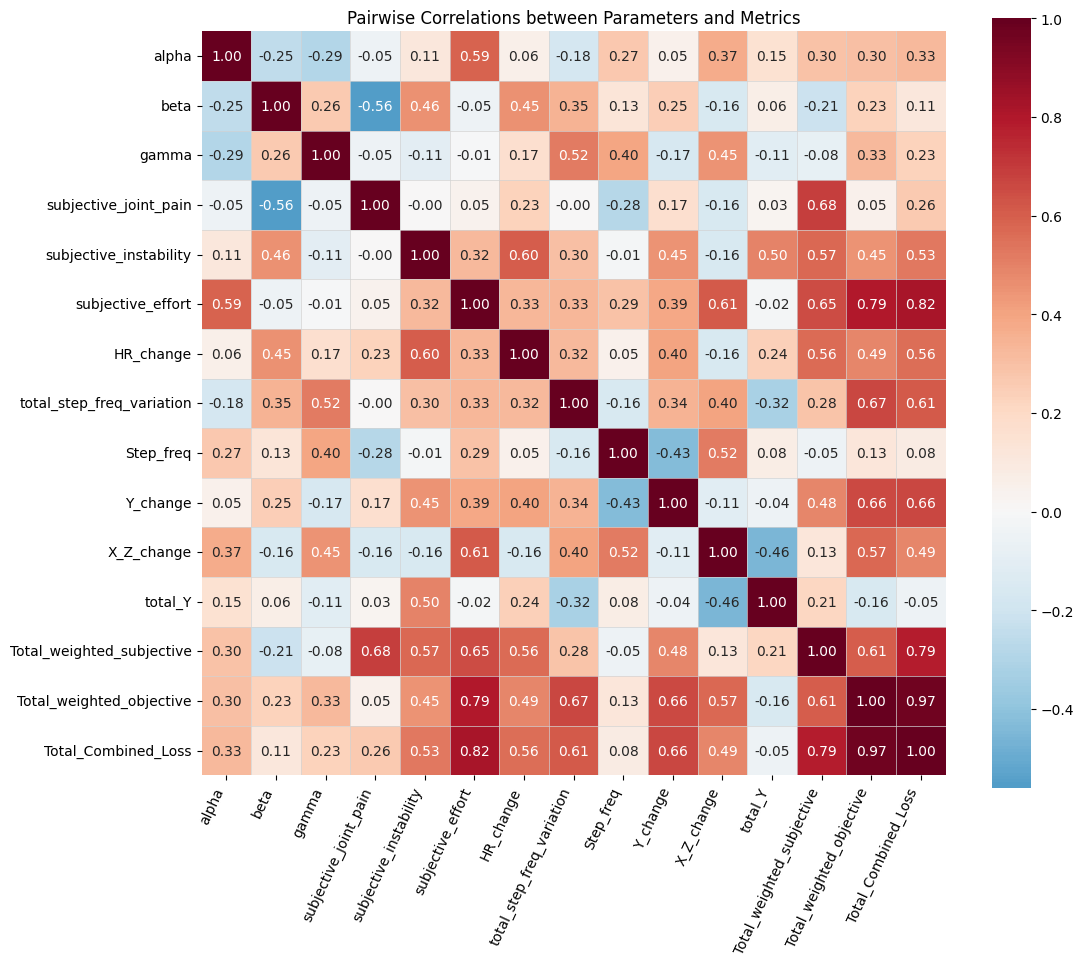

In [ ]:
#Experiment_metrics_df_sliced = Experiment_metrics_df.iloc[:, 4:]
#Experiment_metrics_df_sliced = Experiment_metrics_df_sliced.drop("Simulated_weighted", axis=1)

Experiment_metrics_df__except_sim = Experiment_metrics_df.drop("Simulated_weighted", axis=1)
plot_symmetric_pairwise_correlation_heatmap(Experiment_metrics_df__except_sim, part = 'full')



In [ ]:
all_correlations = calculate_all_possible_correlations(Experiment_metrics_df.iloc[:, 4:12])

In [ ]:
all_correlations[all_correlations['Correlation'] < -0.4].sort_values(by='Correlation', ascending = True)

In [ ]:
all_correlations[all_correlations['Correlation'] > 0.85].sort_values(by='Correlation', ascending = False)

# BO

In [ ]:
EXPERIMENT = 'BO_loop'

Experiment_metrics_dict = load_pickle_experiment_dict(EXPERIMENT)
Experiment_metrics_df = convert_experiment_dict_to_df(Experiment_metrics_dict)
Experiment_metrics_df

In [ ]:
Y = np.array(list(Experiment_metrics_df['Total_Combined_Loss'])).reshape(-1, 1)
X = Experiment_metrics_df[['alpha', 'beta', 'gamma']].to_numpy()

print(X)
print(Y)

In [ ]:
#Y = np.vstack((Y, [[100]]))

#X = np.vstack((X, [[ 75,125,3]]))

#print(X)
#print(Y)

In [ ]:
def objective_function(X):
    # Assuming 'model' is your pre-trained GPy model
    #Y, _ = model.predict(X)
    return np.array([[0]])


bounds = [
    {'name': 'alpha', 'type': 'discrete', 'domain': np.arange(70, 125, 5).tolist()}, # alpha
    {'name': 'beta',  'type': 'discrete', 'domain': np.arange(90, 145, 5).tolist()}, # beta
    {'name': 'gamma', 'type': 'discrete', 'domain': np.arange(0, 33, 3).tolist()}    # gamma
]
bounds

In [ ]:

"""
If we want to add noise to a specific angle, choose the appropriate feature index (0,1,2)
and set chosen_dim to that index.
To use this modified kernel in the BO, set its kernel to "ker"
"""


chosen_dim = 1   # dim 1 corresponds to the angle BETA: between the forearm and the hand grip. This is the hardest to calculate
noise_level =  1.05 #  Metric_weighting_values_dict['Dim_beta_kern_noise']
ker1 = GPy.kern.White(input_dim=1, variance = noise_level, active_dims=[chosen_dim])
ker2 = GPy.kern.src.stationary.Matern52(3, variance=1, lengthscale=3)
ker = GPy.kern.src.add.Add([ker1, ker2])
ker = ker1 * ker2

myBopt = BayesianOptimization(f=objective_function,               # Objective function
                              domain = bounds,                    # Domain
                              model_type='GP',                    # Model type, using Gaussian Process
                              acquisition_type='EI',              # Acquisition type, using Expected Improvement
                              exact_feval=True,                   # Exact evaluations of the objective
                              initial_design_numdata=X.shape[0],  # Number of initial points
                              kernel = ker)


# Here go the initial points and their corresponding values.
# We do it this way because we don't really have access to the true function, so we will run
# just 1 interation of the BO loop, run the experiment, and add the suggested point to the initial points
# When testing, if we have access to the actual function, things can be more speedy :)
# In this case, change the initial_design_numdata AND comment out the lines "myBopt.X = ... and myyBopt.Y = ..."

myBopt.X = X
myBopt.Y = Y


max_iter = 1  # Define the number of iterations
myBopt.run_optimization(max_iter)

print("Best found parameters:", myBopt.x_opt)
print("Objective function value at x_opt:", myBopt.fx_opt)

# Since we are getting only one data point, there is no need to plot.
#myBopt.plot_convergence()




In [ ]:
K = GPy.kern.src.stationary.Matern52(3, variance=1, lengthscale=3)
dir(K)
print(K.input_sensitivity())

In [ ]:
print(dir(myBopt))
#myBopt.save_report("/content/test")
print(dir(myBopt.model))
print(type(myBopt.model))
print()
print(myBopt.domain)

In [ ]:
print(myBopt.model.model)
print()
print(myBopt.model.get_model_parameters_names())

In [ ]:
"""
bounds = [
    {'name': 'alpha', 'type': 'discrete', 'domain': np.arange(70, 120, 10).tolist()},  # alpha
    {'name': 'beta', 'type': 'discrete', 'domain': np.arange(90, 140, 10).tolist()}, # beta
    {'name': 'gamma', 'type': 'discrete', 'domain': np.arange(0, 30, 10).tolist()} #gamma
]"""
def get_covariance_matrix(myBopt: BayesianOptimization) -> np.ndarray:
    """
    Given a domain and a BayesianOptimization object, return a matrix where each entry is
    the uncertainty of the model at that point.
    """
    alphas = np.arange(70, 125, 5).tolist()
    betas  = np.arange(90, 145, 5).tolist()
    gammas = np.arange(0, 33, 3).tolist()
    #print(len(alphas))

    matrix = np.ones((len(alphas), len(betas), len(gammas)))* -1

    for alpha_index, alpha in enumerate(alphas):
        for beta_index, beta in enumerate(betas):
            for gamma_index, gamma in enumerate(gammas):
                point = np.array([[alpha, beta, gamma]])
                matrix[alpha_index, beta_index, gamma_index] = myBopt.model.predict(point, with_noise=False)[1]

    return matrix



In [ ]:
res = get_covariance_matrix(myBopt)
print(type(res))
print(res.size)
print(res)
print((res < 0.8).sum())

# Visualization

In [ ]:
EXPERIMENT = 'BO_loop'

bo_loop_dict = load_pickle_experiment_dict(EXPERIMENT)
bo_loop_df = convert_experiment_dict_to_df(bo_loop_dict)
bo_loop_df

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Creating a custom color map: green (low) to red (high)
colors = ["#6AA84F", "#FFD966", "#CC0000"]
cmap_name = 'green_red'
n_bins = 100  # Discretizes the interpolation into bins
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

alpha = bo_loop_df['alpha']
beta = bo_loop_df['beta']
gamma = bo_loop_df['gamma']
values = bo_loop_df['Total_Combined_Loss']

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot: using alpha, beta, gamma as coordinates and values for color
img = ax.scatter(alpha, beta, gamma, c=values, cmap=custom_cmap, alpha=1.0, s=40)

# Connecting all points with a line
ax.plot(alpha, beta, gamma, color='gray', marker=None, linestyle="-", alpha=.6)

# Annotations for start and end points
ax.text(alpha.iloc[0], beta.iloc[0], gamma.iloc[0], "Start", color='black')
ax.text(alpha.iloc[-1], beta.iloc[-1], gamma.iloc[-1], "End", color='black')

# Customization
ax.set_xlabel('Alpha Axis')
ax.set_ylabel('Beta Axis')
ax.set_zlabel('Gamma Axis')
ax.set_title('3D Cube Plot with Colored Dots and Trajectory Line')
fig.colorbar(img, ax=ax, label='Value')

# Show plot
plt.show()

In [ ]:
Y = Experiment_metrics_df['Total_Combined_Loss']
Y = np.array(list(Y)).reshape(-1, 1)
X = Experiment_metrics_df[['alpha', 'beta', 'gamma']]
X = X.to_numpy()

print(X)
print(Y)

In [ ]:
np.random.seed(42)

losses = {}
for l in [3, 8, 15, 25]:
  kernel = GPy.kern.Matern52(input_dim=X.shape[1], variance=1., lengthscale=l)
  model = GPy.models.GPRegression(X, Y, kernel, noise_var=1.0)
  losses[l] = []
  alpha = []
  beta = []
  gamma = []
  for i, a in enumerate(np.arange(70, 145, 5)):
      for j, b in enumerate(np.arange(90, 145, 5)):
          for k, c in enumerate(np.arange(0, 33, 3)):
              if a + b < 190:
                continue
              mean = model.predict(np.array([[a, b, c]]))[0]
              alpha.append(a)
              beta.append(b)
              gamma.append(c)
              losses[l].append(mean.flatten().item())
print(len(losses[3]))

In [ ]:
import plotly.graph_objects as go
import numpy as np

# Your custom color map in matplotlib
colors = ["#6AA84F", "#FFD966", "#CC0000"]
loss_colors = ["#00FFFF", "#0047AB"]
n_bins = 100

# Convert matplotlib colormap to Plotly
plotly_cmap = []
for i in range(n_bins):
    frac = i / (n_bins - 1)
    r, g, b, _ = LinearSegmentedColormap.from_list("", colors)(frac)
    plotly_cmap.append([frac, f'rgb({r*255:.0f},{g*255:.0f},{b*255:.0f})'])

loss_cmap = []
for i in range(n_bins):
    frac = i / (n_bins - 1)
    r, g, b, _ = LinearSegmentedColormap.from_list("", loss_colors)(frac)
    loss_cmap.append([frac, f'rgb({r*255:.0f},{g*255:.0f},{b*255:.0f})'])

alpha = pd.Series(alpha)
beta = pd.Series(beta)
gamma = pd.Series(gamma)
values = pd.Series(losses[15])

# Normalize values for color mapping
values_normalized = (values - values.min()) / (values.max() - values.min())

# Create a 3D scatter plot
myfig = go.Figure(data=[go.Scatter3d(
    x=alpha,
    y=beta,
    z=gamma,
    mode='markers',
    marker=dict(
        size=20,
        color=values_normalized,    # Use normalized values for color
        colorscale=loss_cmap,
        colorbar=dict(title='Loss'),
        opacity=.1
    ),
    showlegend=False,
)])

myfig.add_trace(go.Scatter3d(
    x=X[:, 0],
    y=X[:, 1],
    z=X[:, 2],
    mode='markers',
    marker=dict(
        size=10,                   # Larger size for visibility
        color=Y[:, 0],             # Black color
        colorscale=loss_cmap,
        # colorbar=dict(title='Mean'),
        opacity=1
    ),
    showlegend=False,
))

myfig.add_trace(go.Scatter3d(
    x=[85],
    y=[130],
    z=[0],
    mode='markers',
    marker=dict(
        size=10,                   # Larger size for visibility
        color='purple',             # Black color
        opacity=1
    ),
    showlegend=False,
))

# Customization
myfig.update_layout(
    title='3D Cube Plot with Colored Dots',
    scene=dict(
        xaxis_title='Alpha Axis',
        yaxis_title='Beta Axis',
        zaxis_title='Gamma Axis'
    ),
    margin=dict(r=0, b=0, l=0, t=0)
)

myfig.show()

# Sensitivity analysis

In [ ]:
Experiment_metrics_df

In [ ]:
model = myBopt.model.model

emukit_model = GPyModelWrapper(model)

parameter_space = ParameterSpace([ContinuousParameter('alpha', 70, 125),
                                  ContinuousParameter('beta', 90, 145),
                                  ContinuousParameter('gamma', 0, 33)])

num_mc_points = 50000  #ramp this up!!
print(num_mc_points)

sensitivity = MonteCarloSensitivity(model=emukit_model, input_domain=parameter_space)
res = sensitivity.compute_effects(num_monte_carlo_points=num_mc_points)

print("Main Effects:", main_effects)
print("Total Effects:", total_effects)

In [ ]:
def create_emukit_gp_model(X, Y):
    kernel = GPy.kern.Matern52(input_dim=X.shape[1], variance=1., lengthscale=3.)
    gp_model = GPy.models.GPRegression(X, Y, kernel)
    gp_model.optimize()
    return GPyModelWrapper(gp_model)

def emukit_sensitivity_analysis(X, Y):
    model = create_emukit_gp_model(X, Y)

    space = ParameterSpace([
        ContinuousParameter('alpha', 70, 125),
        ContinuousParameter('beta', 90, 145),
        ContinuousParameter('gamma', 0, 33)
    ])

    sensitivity = MonteCarloSensitivity(model=model, input_domain=space)
    main_effects, total_effects, _ = sensitivity.compute_effects(num_monte_carlo_points=50000)

    return {'main_effects': main_effects, 'total_effects': total_effects}

In [ ]:
SI_per_metric = {}
X = Experiment_metrics_df[['alpha', 'beta', 'gamma']].to_numpy()
for col in Experiment_metrics_df.columns[4:]:
  Y = np.array(list(Experiment_metrics_df[col])).reshape(-1, 1)
  SI_per_metric[col] = emukit_sensitivity_analysis(X, Y)
SI_per_metric

# Sensitivity analysis using SALib

In [ ]:
def create_gp_model(X, Y):
    kernel = GPy.kern.Matern52(input_dim=X.shape[1], variance=1., lengthscale=3.)
    model = GPy.models.GPRegression(X, Y, kernel)
    model.optimize(messages=True)
    return model

def sensitivity_analysis(X, Y):
    model = create_gp_model(X, Y)

    problem = {
        'num_vars': X.shape[1],
        'names': ['alpha', 'beta', 'gamma'],
        'bounds': [[70, 125], [90, 145], [0, 33]]
    }

    param_values = saltelli.sample(problem, 10_000)

    Y_pred = model.predict(param_values)[0]
    # print("Y_pred: ", Y_pred)

    si = sobol.analyze(problem, Y_pred.flatten())

    return si

In [ ]:
SI_per_metric = {}
X = Experiment_metrics_df[['alpha', 'beta', 'gamma']].to_numpy()
for col in Experiment_metrics_df.columns[4:]:
  Y = np.array(list(Experiment_metrics_df[col])).reshape(-1, 1)
  SI_per_metric[col] = sensitivity_analysis(X, Y)
SI_per_metric

In [ ]:
def get_s2_interactions(s2):
  alpha_beta = s2[0,1]
  alpha_gamma = s2[0,2]
  beta_gamma = s2[1,2]
  return alpha_beta, alpha_gamma, beta_gamma

get_s2_interactions(SI_per_metric["Total_Combined_Loss"]["S2"])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

SI_per_metric.pop("Simulated_weighted", None)

# Names for the columns
column_names = ['alpha', 'beta', 'gamma', 'alpha-beta', 'alpha-gamma', 'beta-gamma', 'alpha (T)', 'beta (T)', 'gamma (T)']

# Prepare the 2D array for the heatmap and row labels
heatmap_data = []
row_labels = list(SI_per_metric.keys())

for key in SI_per_metric.keys():
    s1_values = SI_per_metric[key]['S1']
    s2_values = get_s2_interactions(SI_per_metric[key]['S2'])
    sT_values = SI_per_metric[key]['ST']
    heatmap_data.append(np.concatenate([s1_values, s2_values, sT_values]))

heatmap_data = np.array(heatmap_data).T

# Create the heatmapplt.figure(figsize=(len(SI_per_metric), 8))
plt.figure(figsize=(len(row_labels), 8))
ax = sns.heatmap(heatmap_data, annot=True, xticklabels=row_labels, yticklabels=column_names, cmap='viridis', square=True)
plt.title('Sensitivity Analysis')

ax.axhline(y=3, color='white', lw=8)  # After S1 values
ax.axhline(y=6, color='white', lw=8)  # After S2 values

plt.xticks(rotation=65, ha='right')
plt.savefig("sensitivity_analysis_l15")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prepare the 2D arrays for the S1 values and the S1_conf values
s1_conf_values = np.array([d['S1_conf'] for d in SI_per_metric.values()]).flatten()
s2_conf_values = np.array([d['S2_conf'] for d in SI_per_metric.values()]).flatten()
sT_conf_values = np.array([d['ST_conf'] for d in SI_per_metric.values()]).flatten()
plt.hist(s1_conf_values, bins=np.arange(0, 1.0, 0.01), alpha=0.5, label="S1")
plt.hist(s2_conf_values, bins=np.arange(0, 1.0, 0.01), alpha=0.5, label="S2")
plt.hist(sT_conf_values, bins=np.arange(0, 1.0, 0.01), alpha=0.5, label="ST")
plt.title("Histogram of Confidence Intervals")
plt.xlabel("Confidence Interval")
plt.ylabel("Count")
plt.legend()
plt.savefig("si_confidence_intervals_l3")
plt.show()

# Previous unused code

In [ ]:
"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming Accelerometer_df_only_bouts is your DataFrame

# Count the number of unique bouts
num_bouts = len(Accelerometer_df_only_bouts['Crutch_bout'].unique())

# Determine the 99th percentile range for x-axis and y-axis for each axis
percentile_ranges = {}
percentile_freqs = {}
for axis in ['acc_x_data', 'acc_y_data', 'acc_z_data']:
    all_data = np.sqrt(Accelerometer_df_only_bouts[axis]**2)
    percentile_ranges[axis] = (0, np.percentile(all_data, 99))

    hist, bin_edges = np.histogram(all_data, bins=100, range=(0, percentile_ranges[axis][1]))
    percentile_freqs[axis] = np.percentile(hist, 80)

# Create subplots
fig, axs = plt.subplots(3, num_bouts, figsize=(20, 10), constrained_layout=True)

# Iterate over each unique bout
for i, bout in enumerate(sorted(Accelerometer_df_only_bouts['Crutch_bout'].unique())):
    bout_data = Accelerometer_df_only_bouts[Accelerometer_df_only_bouts['Crutch_bout'] == bout]

    for j, axis in enumerate(['acc_x_data', 'acc_y_data', 'acc_z_data']):
        Pos_acc = np.sqrt(bout_data[axis]**2)
        mean_val = Pos_acc.mean()
        std_val = Pos_acc.std()
        AUC = Pos_acc.sum()

        # Plot histogram in the corresponding subplot
        axs[j, i].hist(Pos_acc, bins=100, range=percentile_ranges[axis])
        axs[j, i].set_ylim(0, percentile_freqs[axis])
        axs[j, i].set_title(f'Bout {bout}\nAxis: {axis[-1].upper()}\nMean: {mean_val:.2f}, Std: {std_val:.2f}, \n Total: {AUC:.2f}')
        axs[j, i].set_xlabel('Positive Acceleration')
        axs[j, i].set_ylabel('Frequency')

# Show the plot
plt.show()
"""

In [ ]:
"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming Accelerometer_df_only_bouts is your DataFrame

# Count the number of unique bouts
num_bouts = len(Accelerometer_df_only_bouts['Crutch_bout'].unique())

# Create a figure with subplots - adding 1 for the combined plot
fig, axs = plt.subplots(num_bouts + 1, 1, figsize=(10, 5 * (num_bouts + 1)))

# Define a color palette for each subplot for consistency
color_palette = plt.cm.viridis(np.linspace(0, 1, num_bouts + 1))

# Plot for all bouts combined in the first subplot
axs[0].plot(np.abs(Accelerometer_df_only_bouts['acc_x_data']) + Accelerometer_df_only_bouts['acc_z_data'], label='All Bouts Combined', color=color_palette[0])
axs[0].set_title('All Bouts Combined', fontsize=14)
axs[0].set_xlabel('Index', fontsize=12)
axs[0].set_ylabel('Sum of Abs(acc_x_data) and acc_z_data', fontsize=12)
axs[0].legend()
axs[0].grid(True)  # Add gridlines for easier reading

# Iterate over each unique bout for the rest of the subplots
for i, bout in enumerate(sorted(Accelerometer_df_only_bouts['Crutch_bout'].unique())):
    bout_data = Accelerometer_df_only_bouts[Accelerometer_df_only_bouts['Crutch_bout'] == bout]
    axs[i + 1].plot(np.abs(bout_data['acc_x_data']) + bout_data['acc_z_data'], label=f'Bout {bout}', color=color_palette[i + 1])
    axs[i + 1].set_title(f'Bout {bout}', fontsize=14)
    axs[i + 1].set_xlabel('Index', fontsize=12)
    axs[i + 1].set_ylabel('Sum of Abs(acc_x_data) and acc_z_data', fontsize=12)
    axs[i + 1].legend()
    axs[i + 1].grid(True)  # Add gridlines for easier reading

# Adjust layout
plt.tight_layout(h_pad=2)  # Add more space between plots

# Show the plot
plt.show()

"""

In [ ]:
"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming Accelerometer_df_only_bouts is your DataFrame

# Count the number of unique bouts
num_bouts = len(Accelerometer_df_only_bouts['Crutch_bout'].unique())

# Create a figure with subplots
fig, axs = plt.subplots(1, num_bouts, figsize=(20, 5))

# Ensure axs is an array even if there is only one subplot
if num_bouts == 1:
    axs = [axs]

# Iterate over each unique bout
for i, bout in enumerate(sorted(Accelerometer_df_only_bouts['Crutch_bout'].unique())):
    bout_data = Accelerometer_df_only_bouts[Accelerometer_df_only_bouts['Crutch_bout'] == bout]
    Pos_acc = np.sqrt(bout_data['acc_z_data']**2)

    mean_val = Pos_acc.mean()
    std_val = Pos_acc.std()
    AUC = Pos_acc.sum()

    # Plot histogram in the ith subplot
    axs[i].hist(Pos_acc, bins=100)
    axs[i].set_title(f'Bout {bout}\nMean: {mean_val:.2f}, \n Std: {std_val:.2f}, \n total: {AUC:.2f}')
    axs[i].set_xlabel('Positive Y Acceleration')
    axs[i].set_ylabel('Frequency')
    axs[i].set_ylim(0, 250)

# Adjust layout
#plt.tight_layout()

# Show the plot
plt.show()
"""